## Load the dataset

In [212]:
import sys

sys.path.append('..')

In [213]:
import numpy as np
import pandas as pd

df = pd.read_csv('../processed_data/tabular_data/data.csv', index_col=None)
label = df['label'].astype(int).to_numpy()
df.drop(columns=['label'], axis=1, inplace=True)
data = df.to_numpy()

In [214]:
from audio_toolbox.metrics import audio_dataset_split

RANDOM_STATE = 42
X_train, y_train, _, _, X_test, y_test = \
    audio_dataset_split(data, label, train_val_test_ratio=(0.9, 0, 0.1), random_state=RANDOM_STATE)

In [215]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# Fit the scaler on the training set and transform all sets
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Try different models

In [216]:
RANDOM_STATE = 42
np.random.seed(42)

In [217]:
import matplotlib.pyplot as plt
from audio_toolbox.metrics import calculate_acc, precision_recall, visualize_confusion_matrices

def fit_and_evaluate_model(model, X_train, y_train, X_test, y_test, model_name='Model'):
    model.fit(X_train, y_train)
    print('Model fitting finished')

    conf_mats = []
    for x, y, split in zip([X_train, X_test],
                    [y_train, y_test],
                    ['Train', 'Test']):
        acc, correct, incorrect = calculate_acc(model, x, y)
        print(f'{split} accuracy: {acc:.4f}%, {len(incorrect)} mismatches out of {len(incorrect) + len(correct)} samples')
        conf_mat, precision, recall, f1 = precision_recall(model, x, y, return_each_class=False)
        conf_mats.append(conf_mat)
        print(f'(Averaged) {split} precision: {precision:.4f}, recall: {recall:.4f}, f1 score: {f1:.4f}')
        
    visualize_confusion_matrices(conf_mats,
                                titles=('Train', 'Test'),
                                grand_title=f'Confusion matrices for {model_name}')

Model fitting finished
Train accuracy: 85.4283%, 131 mismatches out of 899 samples
(Averaged) Train precision: 0.8536, recall: 0.8539, f1 score: 0.8535
Test accuracy: 71.0000%, 29 mismatches out of 100 samples
(Averaged) Test precision: 0.6942, recall: 0.7093, f1 score: 0.6974


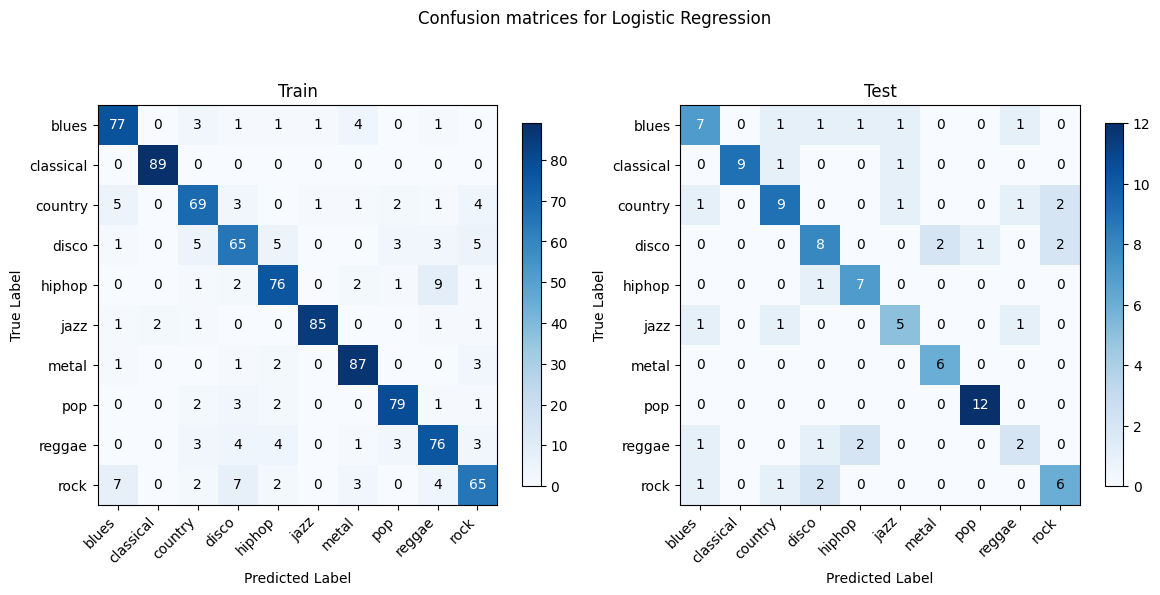

In [218]:
from sklearn.linear_model import LogisticRegression

logistic_model = LogisticRegression(max_iter=1000, random_state=RANDOM_STATE)
fit_and_evaluate_model(logistic_model, X_train, y_train, X_test, y_test, 'Logistic Regression')

Model fitting finished
Train accuracy: 88.2091%, 106 mismatches out of 899 samples
(Averaged) Train precision: 0.8866, recall: 0.8819, f1 score: 0.8829
Test accuracy: 73.0000%, 27 mismatches out of 100 samples
(Averaged) Test precision: 0.7226, recall: 0.7302, f1 score: 0.7189


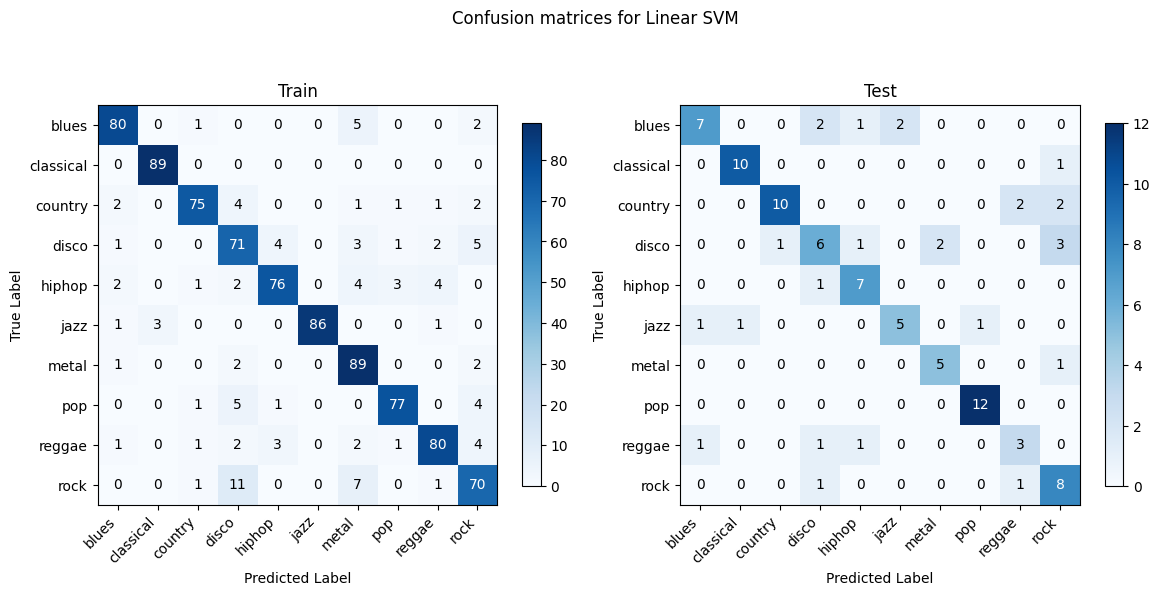

In [219]:
from sklearn.svm import SVC

svm_classifier = SVC(kernel='rbf', C=1, random_state=RANDOM_STATE)
fit_and_evaluate_model(svm_classifier, X_train, y_train, X_test, y_test, 'Linear SVM')

Model fitting finished
Train accuracy: 93.3259%, 60 mismatches out of 899 samples
(Averaged) Train precision: 0.9365, recall: 0.9334, f1 score: 0.9340
Test accuracy: 74.0000%, 26 mismatches out of 100 samples
(Averaged) Test precision: 0.7413, recall: 0.7422, f1 score: 0.7386


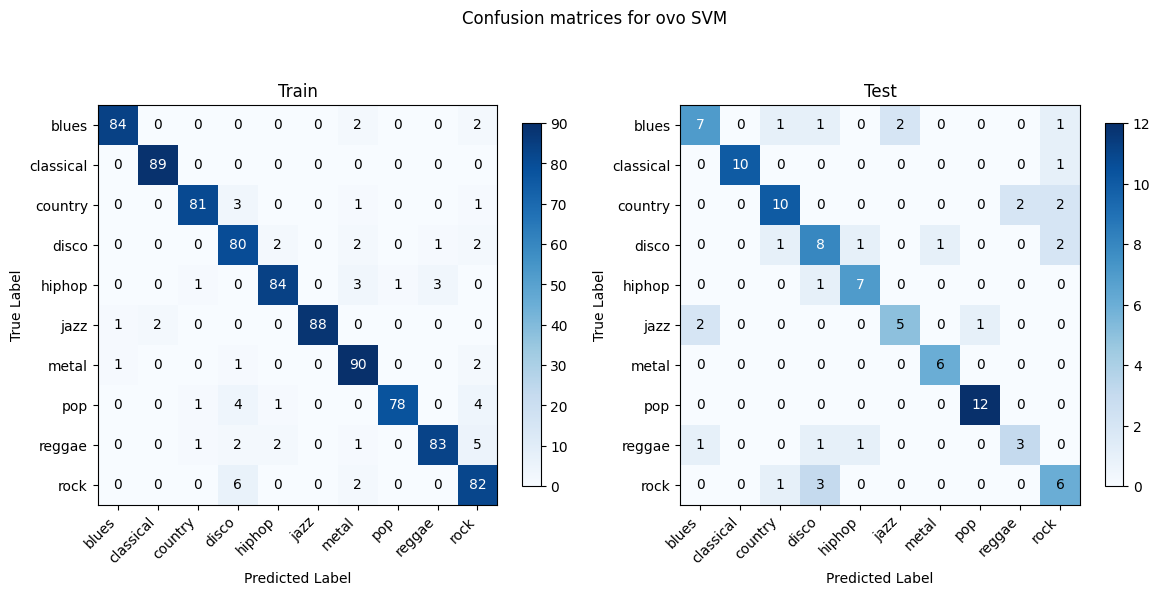

In [220]:
from sklearn.svm import SVC

ovo_svm = SVC(kernel='rbf', decision_function_shape='ovo', C=2, random_state=RANDOM_STATE)
fit_and_evaluate_model(ovo_svm, X_train, y_train, X_test, y_test, 'ovo SVM')

Model fitting finished
Train accuracy: 99.7775%, 2 mismatches out of 899 samples
(Averaged) Train precision: 0.9978, recall: 0.9978, f1 score: 0.9978
Test accuracy: 74.0000%, 26 mismatches out of 100 samples
(Averaged) Test precision: 0.7338, recall: 0.7471, f1 score: 0.7321


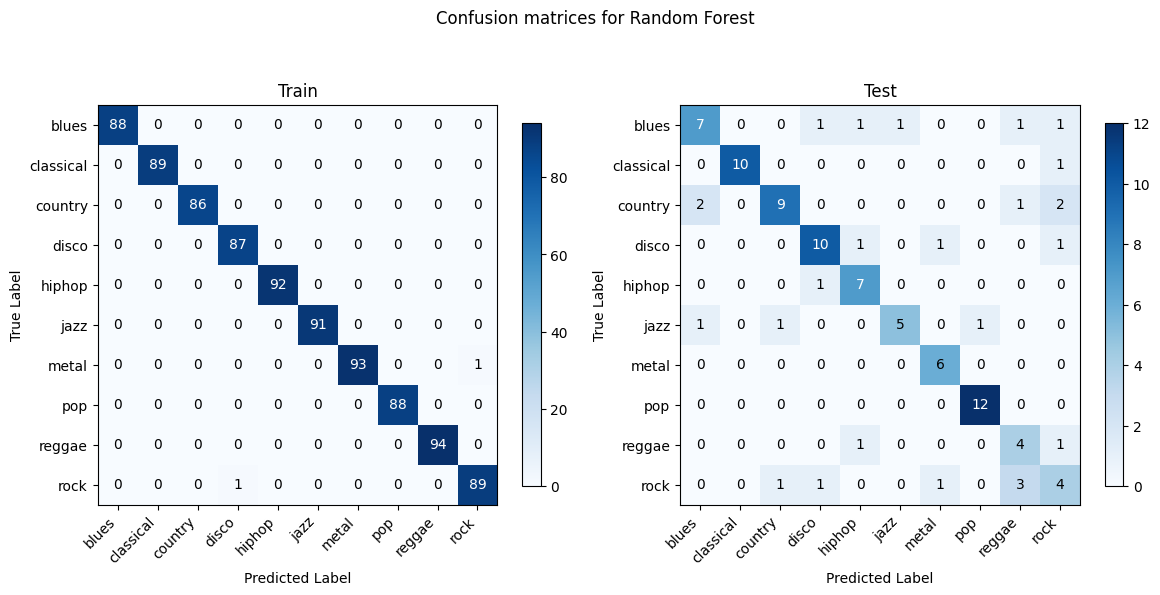

In [221]:
from sklearn.ensemble import RandomForestClassifier

rand_forest_classifier = RandomForestClassifier(max_depth=10,
                                                max_features=10,
                                                random_state=RANDOM_STATE)
fit_and_evaluate_model(rand_forest_classifier, X_train, y_train, X_test, y_test, 'Random Forest')

Model fitting finished
Train accuracy: 58.1758%, 376 mismatches out of 899 samples
(Averaged) Train precision: 0.6005, recall: 0.5813, f1 score: 0.5742
Test accuracy: 56.0000%, 44 mismatches out of 100 samples
(Averaged) Test precision: 0.5907, recall: 0.5625, f1 score: 0.5369


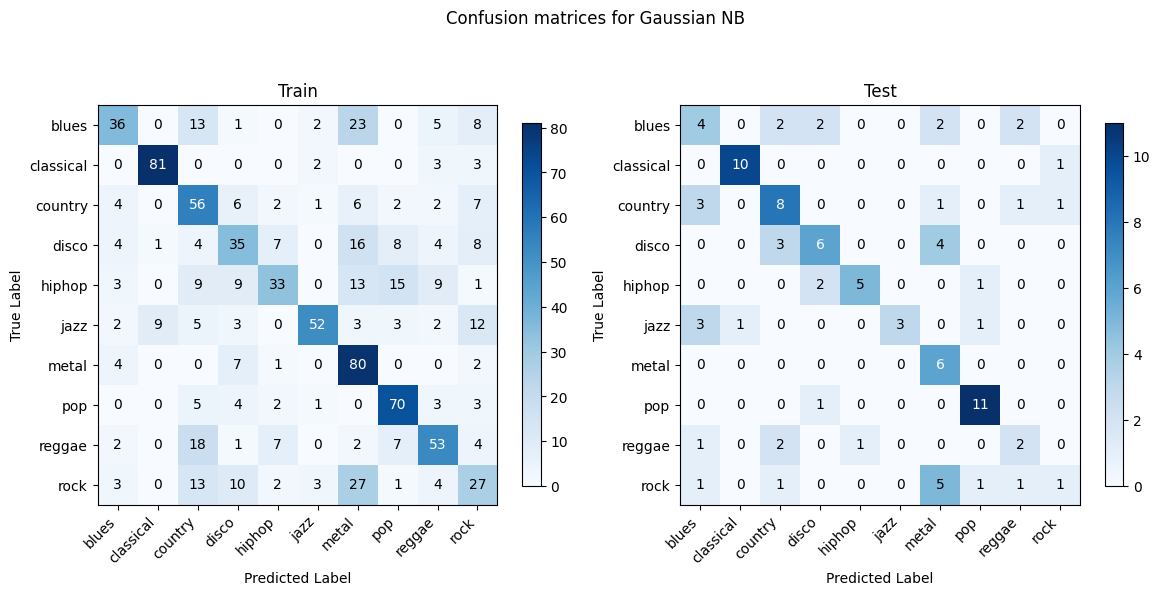

In [222]:
from sklearn.naive_bayes import GaussianNB

gnb_classifier = GaussianNB()
fit_and_evaluate_model(gnb_classifier, X_train, y_train, X_test, y_test, 'Gaussian NB')

Model fitting finished
Train accuracy: 99.8888%, 1 mismatches out of 899 samples
(Averaged) Train precision: 0.9989, recall: 0.9989, f1 score: 0.9989
Test accuracy: 80.0000%, 20 mismatches out of 100 samples
(Averaged) Test precision: 0.8063, recall: 0.7943, f1 score: 0.7911


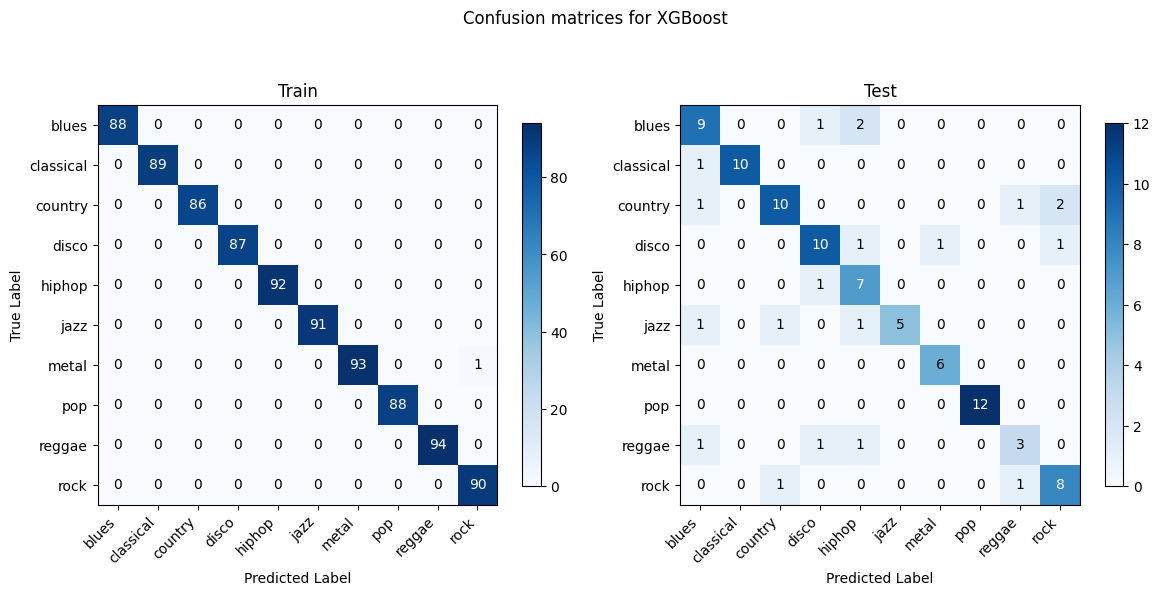

In [223]:
from sklearn.ensemble import GradientBoostingClassifier

xgboost_classifier = GradientBoostingClassifier(max_depth=10, max_features=10, random_state=RANDOM_STATE)
fit_and_evaluate_model(xgboost_classifier, X_train, y_train, X_test, y_test, 'XGBoost')

In [224]:
current_models = [logistic_model, svm_classifier, ovo_svm, rand_forest_classifier, gnb_classifier, xgboost_classifier]
current_model_names = ["Logistic", "SVM", "OVO SVM", "Random Forest", "Gaussian NB", "XGBoost"]

In [225]:
from audio_toolbox.metrics import kfold_validation
import warnings

N_SPLITS = 5

accs = {}
f1s = {}

scaled_data = scaler.transform(data)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for model, name in zip(current_models, current_model_names):
        print(f"Benchmarking {name}")
        avg_acc, avg_precision, avg_recall, avg_f1 = kfold_validation(model, scaled_data, label, n_splits=N_SPLITS)
        accs[name] = avg_acc
        f1s[name] = avg_f1
        print(f"Average Accuracy: {avg_acc:.4f}")
        print(f"Average Precision: {avg_precision:.4f}")
        print(f"Average Recall: {avg_recall:.4f}")
        print(f"Average F1 Score: {avg_f1:.4f}")
        print()


Benchmarking Logistic


Average Accuracy: 70.1719
Average Precision: 0.7035
Average Recall: 0.7020
Average F1 Score: 0.6995

Benchmarking SVM
Average Accuracy: 69.2653
Average Precision: 0.7038
Average Recall: 0.6929
Average F1 Score: 0.6901

Benchmarking OVO SVM
Average Accuracy: 72.8678
Average Precision: 0.7394
Average Recall: 0.7289
Average F1 Score: 0.7274

Benchmarking Random Forest
Average Accuracy: 66.8633
Average Precision: 0.6757
Average Recall: 0.6689
Average F1 Score: 0.6642

Benchmarking Gaussian NB
Average Accuracy: 52.7523
Average Precision: 0.5469
Average Recall: 0.5275
Average F1 Score: 0.5146

Benchmarking XGBoost
Average Accuracy: 69.6648
Average Precision: 0.7064
Average Recall: 0.6969
Average F1 Score: 0.6941



In [226]:
import matplotlib.pyplot as plt
import numpy as np
def create_bar_chart(data, title, ylabel):
    models = list(data.keys())
    scores = list(data.values())
    fig, ax = plt.subplots(figsize=(6, 4))
    bar_positions = np.arange(len(models))
    ax.bar(bar_positions, scores, color='skyblue')
    for i, v in enumerate(scores):
        ax.text(i, v + 0.01, "{:.2f}".format(v), ha='center', va='bottom')

    ax.set_xticks(bar_positions)
    ax.set_xticklabels(models, rotation=45)
    ax.set_ylabel(ylabel)
    ax.set_title(title)

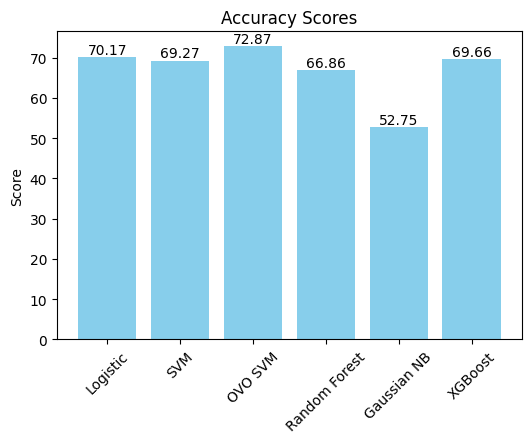

In [227]:
create_bar_chart(accs, "Accuracy Scores", "Score")
plt.show();

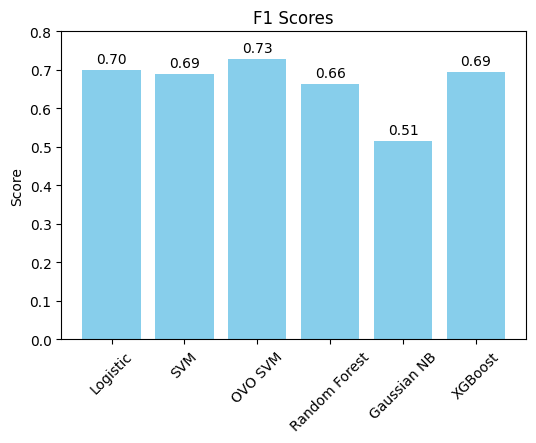

In [228]:
create_bar_chart(f1s, "F1 Scores", "Score")
plt.ylim(top=0.8)
plt.show();